# Библиотеки

In [ ]:
pip install pymorphy2

     |████████████████████████████████| 55 kB 1.8 MB/s 
     |████████████████████████████████| 8.2 MB 21.1 MB/s 


In [ ]:
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, GlobalMaxPooling1D, LSTM, GRU, Bidirectional, Embedding, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import RMSprop, Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import pymorphy2
import seaborn as sns
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from datetime import datetime
import statistics
%matplotlib inline 

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid")

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import timedelta

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import tensorflow as tf
tf.random.set_seed(0)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers, backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
from google.colab import files 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
directory= '/content/drive/My Drive/Базы/временные ряды/'

# Подготовка данных

In [ ]:
filename=pd.read_csv(directory+'bitstampUSD.csv')

In [ ]:
new_pd=filename.head(100000)

In [ ]:
correct_date=[]

scaler = MinMaxScaler(feature_range=(0, 1))
for j in range(0, len(new_pd)):
  timestamp=new_pd['Timestamp'][j]
  correct_date.append(datetime.fromtimestamp(timestamp))
new_pd['correct_date'] = correct_date
for i in range(0, len(new_pd)):
  if np.isnan(new_pd['Weighted_Price'][i]) ==True:
    new_pd.drop(index=i,axis = 0,inplace=True)
new_pd['NormalizedPrices'] = scaler.fit_transform(new_pd['Weighted_Price'].values.reshape(-1, 1)).flatten()
new_pd.index=new_pd['correct_date']
new_pd.drop(['Timestamp','Open','High','Low','Close','Volume_(BTC)','Volume_(Currency)','correct_date'], axis=1, inplace=True)

In [ ]:
def create_dataset(data, enc_timesteps=ENCODER_TIMESTEPS, dec_timesteps=DECODER_TIMESTEPS):
    X_encoder, X_decoder, y, y_date, start_values = [], [], [], [], []
    
    for i in range(len(data) - enc_timesteps - dec_timesteps):
        Xt_encoder = data.iloc[i:i+enc_timesteps].values
        Xt_decoder = data.iloc[i+enc_timesteps-dec_timesteps:i+enc_timesteps].values
        yt = data.iloc[i+enc_timesteps:i+enc_timesteps+dec_timesteps].values
        yt_date = data.index[i+enc_timesteps].to_pydatetime() 
        start_value = Xt_encoder[0]
        Xt_encoder = Xt_encoder - start_value
        Xt_decoder = Xt_decoder - start_value
        yt = yt - start_value
        
        X_encoder.append(Xt_encoder)
        X_decoder.append(Xt_decoder)
        y.append(yt)
        y_date.append(yt_date)
        start_values.append(start_value)
        
    return np.array(X_encoder), np.array(X_decoder), np.array(y), y_date, start_values

In [ ]:
def split_train_valid_test(X_encoder, X_decoder, y, y_date, train_range=TRAIN_RANGE, valid_range=VALID_RANGE, test_range=TEST_RANGE):
    train_end_idx = y_date.index(train_range[1])
    valid_end_idx = y_date.index(valid_range[1])
    
    X_encoder_train = X_encoder[:train_end_idx+1, :]
    X_encoder_valid = X_encoder[train_end_idx+1:valid_end_idx+1, :] 
    X_encoder_test = X_encoder[valid_end_idx+1:, :]
    
    X_decoder_train = X_decoder[:train_end_idx+1, :]
    X_decoder_valid = X_decoder[train_end_idx+1:valid_end_idx+1, :] 
    X_decoder_test = X_decoder[valid_end_idx+1:, :]
    
    y_train = y[:train_end_idx+1]
    y_valid = y[train_end_idx+1:valid_end_idx+1] #!!
    y_test = y[valid_end_idx+1:]
    
    y_date_train = y_date[:train_end_idx+1]
    y_date_valid = y_date[train_end_idx+1:valid_end_idx+1]
    y_date_test = y_date[valid_end_idx+1:]
    
    return X_encoder_train, X_decoder_train, X_encoder_valid, X_decoder_valid, X_encoder_test, X_decoder_test, y_train, y_valid, y_test, y_date_train, y_date_valid, y_date_test

# Проверка выборки

In [ ]:
TRAIN_RANGE=(min(y_date),statistics.median(y_date)) # 624 (от 0 до 624)       
VALID_RANGE=(y_date[y_date.index(TRAIN_RANGE[1])+1], y_date[int(y_date.index(max(y_date))-y_date.index(y_date[y_date.index(TRAIN_RANGE[1])+1])/2)]) # 310 (от 625 lj 935)
TEST_RANGE=(y_date[y_date.index(VALID_RANGE[1])+1],max(y_date)) #end(6)

ENCODER_TIMESTEPS=12
DECODER_TIMESTEPS=6

In [ ]:
X_encoder, X_decoder, y, y_date, start_values = create_dataset(new_pd[['NormalizedPrices']])

In [ ]:
X_encoder_train, X_decoder_train, X_encoder_valid, X_decoder_valid, X_encoder_test, X_decoder_test, y_train, y_valid, y_test, y_date_train, y_date_valid, y_date_test = split_train_valid_test(X_encoder, X_decoder, y, y_date)

In [ ]:
print(X_encoder_train.shape, X_encoder_valid.shape, X_encoder_test.shape)
print(X_decoder_train.shape, X_decoder_valid.shape, X_decoder_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(625, 12, 1) (311, 12, 1) (313, 12, 1)
(625, 6, 1) (311, 6, 1) (313, 6, 1)
(625, 6, 1) (311, 6, 1) (313, 6, 1)


# Создание НС

In [ ]:
def create_model(enc_timesteps=ENCODER_TIMESTEPS, dec_timesteps=DECODER_TIMESTEPS):
    encoder_inputs = Input(shape=(enc_timesteps, 1), name='encoder_input')
    encoder, state_h1, state_c1 = LSTM(128, return_sequences=True, return_state=True, name='encoder_lstm_1')(encoder_inputs)
    encoder_states1 = [state_h1, state_c1]
    encoder_outputs, state_h2, state_c2 = LSTM(32, return_state=True, name='encoder_lstm_2')(encoder)
    encoder_states2 = [state_h2, state_c2]

    decoder_inputs = Input(shape=(dec_timesteps, 1), name='decoder_input')    
    decoder, _, _ = LSTM(128, return_sequences=True, return_state=True, name='decoder_lstm_1')(decoder_inputs, initial_state=encoder_states1)
    decoder, _, _ = LSTM(32, return_sequences=True, return_state=True, name='decoder_lstm_2')(decoder, initial_state=encoder_states2)
    decoder_outputs = Dense(1)(decoder)
    
    model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)
    model.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr=0.01), metrics=['mean_absolute_error'])
    return model

In [ ]:
model = create_model()

In [ ]:
es = EarlyStopping(monitor='val_mean_absolute_error', min_delta=0, patience=15, verbose=1, mode='auto')
fn = 'trained_model.h5'
mc = ModelCheckpoint(filepath=fn, save_best_only=True)
callbacks = [es, mc]

In [ ]:
fit = model.fit(
    [X_encoder_train, X_decoder_train], y_train, 
    batch_size=32,
    epochs=10, 
    verbose=2,
    validation_data=([X_encoder_valid, X_decoder_valid], y_valid), 
    callbacks=callbacks)

Epoch 1/10
20/20 - 14s - loss: 0.0131 - mean_absolute_error: 0.0845 - val_loss: 0.0052 - val_mean_absolute_error: 0.0509 - 14s/epoch - 695ms/step
Epoch 2/10
20/20 - 1s - loss: 0.0081 - mean_absolute_error: 0.0621 - val_loss: 0.0041 - val_mean_absolute_error: 0.0478 - 654ms/epoch - 33ms/step
Epoch 3/10
20/20 - 1s - loss: 0.0076 - mean_absolute_error: 0.0601 - val_loss: 0.0039 - val_mean_absolute_error: 0.0400 - 835ms/epoch - 42ms/step
Epoch 4/10
20/20 - 1s - loss: 0.0072 - mean_absolute_error: 0.0569 - val_loss: 0.0038 - val_mean_absolute_error: 0.0440 - 643ms/epoch - 32ms/step
Epoch 5/10
20/20 - 1s - loss: 0.0072 - mean_absolute_error: 0.0579 - val_loss: 0.0039 - val_mean_absolute_error: 0.0463 - 598ms/epoch - 30ms/step
Epoch 6/10
20/20 - 1s - loss: 0.0075 - mean_absolute_error: 0.0585 - val_loss: 0.0037 - val_mean_absolute_error: 0.0442 - 637ms/epoch - 32ms/step
Epoch 7/10
20/20 - 1s - loss: 0.0076 - mean_absolute_error: 0.0603 - val_loss: 0.0036 - val_mean_absolute_error: 0.0413 - 64

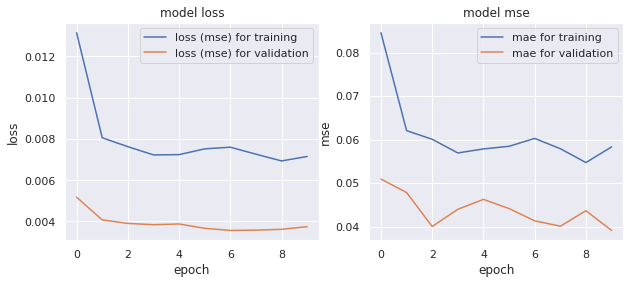

In [ ]:
# Результаты обучения модели
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10, 4))
axL.plot(fit.history['loss'], label="loss (mse) for training")
axL.plot(fit.history['val_loss'], label="loss (mse) for validation")
axL.set_title('model loss')
axL.set_xlabel('epoch')
axL.set_ylabel('loss')
axL.legend(loc='upper right')

axR.plot(fit.history['mean_absolute_error'], label="mae for training")
axR.plot(fit.history['val_mean_absolute_error'], label="mae for validation")
axR.set_title('model mse')
axR.set_xlabel('epoch')
axR.set_ylabel('mse')
axR.legend(loc='upper right')
plt.show()

model = load_model(fn)

# Отображение предсказания

In [ ]:
def evaluate_model(data, scaler, X_encoder_train, X_decoder_train, X_encoder_valid, X_decoder_valid, \
                   X_encoder_test, X_decoder_test, y_train, y_valid, y_test, y_date_train, y_date_valid, y_date_test, start_values, model, \
                  pred_timesteps=0):

    pred_train = model.predict([X_encoder_train, X_decoder_train])[:, pred_timesteps]
    pred_valid = model.predict([X_encoder_valid, X_decoder_valid])[:, pred_timesteps]
    pred_test = model.predict([X_encoder_test, X_decoder_test])[:, pred_timesteps]
    
    pred_train  = pred_train + start_values[:len(X_encoder_train)]
    pred_valid  = pred_valid + start_values[len(X_encoder_train):len(X_encoder_train)+len(X_encoder_valid)]
    pred_test  = pred_test + start_values[len(X_encoder_train)+len(X_encoder_valid):]
    
    pred_train = scaler.inverse_transform(pred_train).flatten()
    pred_valid = scaler.inverse_transform(pred_valid).flatten()
    pred_test = scaler.inverse_transform(pred_test).flatten()
    
    pred_df = pd.DataFrame({
        'Weighted_Price': data['Weighted_Price'].values,
        'PredictionTrain': np.nan, 'PredictionValid': np.nan, 'PredictionTest': np.nan
    })
    
    train_start_idx = ENCODER_TIMESTEPS + pred_timesteps
    valid_start_idx = train_start_idx + len(pred_train)
    test_start_idx = valid_start_idx + len(pred_valid)
    
    pred_df.loc[train_start_idx:valid_start_idx - 1, 'PredictionTrain'] = pred_train
    pred_df.loc[valid_start_idx:test_start_idx-1, 'PredictionValid'] = pred_valid
    pred_df.loc[test_start_idx:test_start_idx+ len(pred_test)-1, 'PredictionTest'] = pred_test
    
    pred_df.idx =  data.index
    pred_df[['Weighted_Price', 'PredictionTrain', 'PredictionValid', 'PredictionTest']].plot(figsize=(12, 6), title='Predicted monthly Weighted_Price')
    
    y_train  = y_train[:, pred_timesteps] + start_values[:len(X_encoder_train)]
    y_valid  = y_valid[:, pred_timesteps] + start_values[len(X_encoder_train):len(X_encoder_train)+len(X_encoder_valid)]
    y_test  = y_test[:, pred_timesteps] + start_values[len(X_encoder_train)+len(X_encoder_valid):]
    
    y_train = scaler.inverse_transform(y_train).flatten()
    y_valid = scaler.inverse_transform(y_valid).flatten()
    y_test = scaler.inverse_transform(y_test).flatten()
    
    for y, pred, mode in zip([y_train, y_valid, y_test], [pred_train, pred_valid, pred_test], ['train', 'valid', 'test']):
        rmse = np.sqrt(mean_squared_error(y, pred))
        mae = mean_absolute_error(y, pred)
        print(f'{mode} rmse: {rmse:.06f}, mae: {mae:.06f}')

train rmse: 0.251648, mae: 0.160584
valid rmse: 0.161265, mae: 0.111031
test rmse: 0.080068, mae: 0.062612


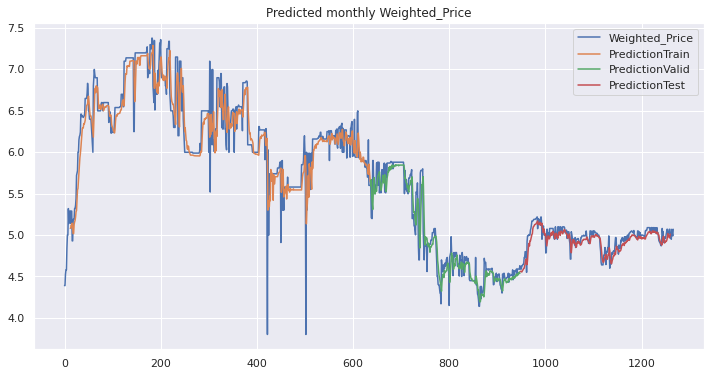

In [ ]:
evaluate_model(new_pd, scaler, X_encoder_train, X_decoder_train, X_encoder_valid, X_decoder_valid, \
               X_encoder_test, X_decoder_test, y_train, y_valid, y_test, y_date_train, y_date_valid, y_date_test, start_values, model, \
              pred_timesteps=0)